In [ ]:
# 📦 Installazione dipendenze
!pip install -q torchaudio transformers librosa pandas scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.2 MB/s eta 0:00:00


In [ ]:
# 📁 Monta Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 🔄 Estrai dataset (modifica i percorsi se necessario)
!unzip -q "/content/drive/MyDrive/warblrb10k_public_wav.zip" -d "/content/warblrb10k"

In [ ]:
# 📚 Carica metadata CSV
import pandas as pd
from pathlib import Path # Import Path
df = pd.read_csv("/content/drive/MyDrive/warblrb10k_public_metadata_2018.csv")

# Print the column names to identify the correct one
print(df.columns)

# Replace 'filename' below with the correct column name found in the output above
df["filepath"] = df["itemid"].apply(lambda f: f"/content/warblrb10k/wav/" + f + ".wav")

df = df[df["filepath"].apply(lambda f: Path(f).exists())]  # elimina file mancanti
df = df.sample(frac=1).reset_index(drop=True)  # shuffle

Index(['itemid', 'datasetid', 'hasbird'], dtype='object')


In [ ]:
print(df.size)

32000


In [ ]:
from pathlib import Path

for f in df["filepath"].head(32000):
    print(f, Path(f).exists())

/content/warblrb10k/wav/ac7f3cb0-bd70-44fb-ac53.wav True
/content/warblrb10k/wav/472bbd15-5ab6-46de-b72f.wav True
/content/warblrb10k/wav/3e25da48-93ce-4c9e-a45b.wav True
/content/warblrb10k/wav/0b755770-cac3-4962-bc8f.wav True
/content/warblrb10k/wav/4a5c7c80-2f36-4983-8dfa.wav True
/content/warblrb10k/wav/76564868-0536-4960-a603.wav True
/content/warblrb10k/wav/18e167a8-dde4-4350-b904.wav True
/content/warblrb10k/wav/eb629913-f106-474e-aea6.wav True
/content/warblrb10k/wav/8af2057c-724a-4430-b0bd.wav True
/content/warblrb10k/wav/bf57380d-4f9f-4613-812e.wav True
/content/warblrb10k/wav/fd011088-d295-466a-a814.wav True
/content/warblrb10k/wav/4e8b6ac7-6993-4535-8335.wav True
/content/warblrb10k/wav/1c185660-38b3-4be6-8b1c.wav True
/content/warblrb10k/wav/8949c3d7-bc57-4af9-b1d9.wav True
/content/warblrb10k/wav/67d3c3b1-6e7b-41df-b67f.wav True
/content/warblrb10k/wav/8c5e8787-2d8d-46af-8ddf.wav True
/content/warblrb10k/wav/f1a0251d-407c-4a41-940d.wav True
/content/warblrb10k/wav/abd9394

In [ ]:
# 🔊 Preprocessing audio
import torchaudio
import torch
from torchaudio.transforms import Resample

In [ ]:
SAMPLE_RATE = 16000
DURATION = 10
MAX_SAMPLES = SAMPLE_RATE * DURATION

def preprocess_audio(path):
    waveform, sr = torchaudio.load(path)
    if sr != SAMPLE_RATE:
        waveform = Resample(sr, SAMPLE_RATE)(waveform)
    waveform = waveform.mean(dim=0, keepdim=True)  # mono
    if waveform.shape[1] < MAX_SAMPLES:
        padding = MAX_SAMPLES - waveform.shape[1]
        waveform = torch.nn.functional.pad(waveform, (0, padding))
    return waveform[:, :MAX_SAMPLES]

In [ ]:
# 🧠 Carica modello AST preaddestrato
from transformers import AutoFeatureExtractor, AutoModel
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model_ast = AutoModel.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593").to(DEVICE).eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
# 🎛️ Dataset
from torch.utils.data import Dataset, DataLoader, random_split

class BirdDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio = preprocess_audio(row["filepath"]).squeeze().numpy()
        with torch.no_grad():
            inputs = extractor(audio, sampling_rate=SAMPLE_RATE, return_tensors="pt", padding=True)
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
            outputs = model_ast(**inputs)
            emb = outputs.last_hidden_state.mean(dim=1).squeeze().cpu()
        label = torch.tensor(row["hasbird"]).float()
        return emb, label

In [ ]:
# 📦 DataLoader
dataset = BirdDataset(df)
train_len = int(0.7 * len(dataset))
val_len = int(0.15 * len(dataset))
test_len = len(dataset) - train_len - val_len
train_ds, val_ds, test_ds = random_split(dataset, [train_len, val_len, test_len])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)


In [ ]:
print(train_len)
print(val_len)
print(test_len)

5600
1200
1200


In [ ]:
# 🧠 MLP Classificatore
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self, input_dim=768):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze()

model_cls = MLP().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model_cls.parameters(), lr=1e-4)

In [ ]:
# 🔁 Training loop
def train_epoch(loader):
    model_cls.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model_cls(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(loader):
    model_cls.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            logits = model_cls(x)
            prob = torch.sigmoid(logits).cpu()
            pred = (prob > 0.5).int()
            preds.extend(pred.tolist())
            labels.extend(y.int().tolist())
    return preds, labels

In [ ]:
# 🚀 Allenamento
for epoch in range(5):
    loss = train_epoch(train_loader)
    print(f"Epoch {epoch+1}: Loss = {loss:.4f}")


Epoch 1: Loss = 0.3771
Epoch 2: Loss = 0.2599
Epoch 3: Loss = 0.2373
Epoch 4: Loss = 0.2270
Epoch 5: Loss = 0.2175


              precision    recall  f1-score   support

           0       0.90      0.73      0.81       309
           1       0.91      0.97      0.94       891

    accuracy                           0.91      1200
   macro avg       0.91      0.85      0.87      1200
weighted avg       0.91      0.91      0.91      1200



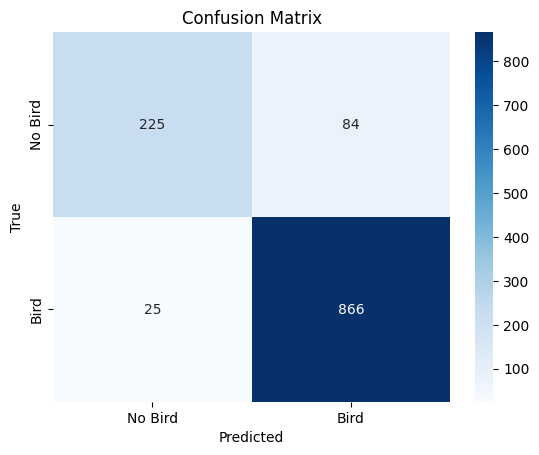

In [ ]:
# 📊 Valutazione finale
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

preds, labels = evaluate(test_loader)
print(classification_report(labels, preds))

# Confusion matrix
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Bird", "Bird"], yticklabels=["No Bird", "Bird"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Classificazione binaria del dataset Warblrb10k con AST (Audio Spectrogram Transformer) come feature extractor e MLP come classificatore.
introducing the Audio Spectrogram Transformer (AST), the first convolution-free, purely attention-based model for audio classification.
Si usa un modello preaddestrato chiamato AST (Audio Spectrogram Transformer), in particolare la versione MIT/ast-finetuned-audioset-10-10-0.4593:

Questo modello prende in input un audio (convertito internamente in spettrogramma) e restituisce un embedding (vettore) che rappresenta le caratteristiche acustiche.

Usi solo l’ultimo stato nascosto medio (outputs.last_hidden_state.mean(dim=1)) come rappresentazione.

🔸 Questo modello è preaddestrato su AudioSet, un enorme dataset di suoni.

Hai un oggetto BirdDataset che:

Prende i metadati (df),

Per ogni elemento esegue il preprocessing audio,

Estrae l’embedding con AST,

Restituisce (embedding, label) dove label = 1.0 se c’è un uccello, 0.0 altrimenti.

Il dataset viene diviso in:

70% training,

15% validation,

15% test.

Classificatore MLP (Multi-Layer Perceptron)

Output = logit (valore continuo)

Funzione di loss: BCEWithLogitsLoss (per classificazione binaria)

https://ar5iv.labs.arxiv.org/html/2104.01778#:~:text=To%20answer%20the%20question%2C%20we%20introduce%20the%20Audio,long-range%20global%20context%20even%20in%20the%20lowest%20layers.